In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg

In [2]:
def flatLCDM(z, H0, Om):
    return H0*np.sqrt(Om*(1 + z)**3 + 1 - Om)

In [3]:
zhzi, hzi, shzi = np.genfromtxt('data/Hz32Clocks.txt', comments='#', usecols=(0,1, 2), unpack=True)

#Covariance data
filename = 'data/data_MM20.dat'
zmod, imf, slib, sps, spsooo = np.genfromtxt(filename, comments='#', usecols=(0,1,2,3,4), unpack=True)

In [4]:
np.random.seed(111)
z_mock = np.random.choice(zhzi, size=100, replace=True)
z_mock = np.sort(np.round(z_mock + np.random.normal(0, 0.01, size=100), 2))
ndata=(len(z_mock))

In [5]:
H0 = 67.4
Om = 0.315

H_real = flatLCDM(z_mock, H0, Om)

In [6]:
sigma_mock = 0.07*H_real

In [7]:
H_obs = np.random.normal(H_real, sigma_mock)

In [14]:
def cov_mat(z_mock, f1, f2):
    cov_mat_diag = np.zeros((ndata, ndata), dtype='float64')
    
    for i in range(ndata):
        cov_mat_diag[i,i] = sigma_mock[i]**2
    
    imf_intp = np.interp(z_mock, zmod, imf)/100
    spsooo_intp = np.interp(z_mock, zmod, spsooo)/100
    
    cov_mat_imf = np.zeros((ndata, ndata), dtype='float64')
    cov_mat_spsooo = np.zeros((ndata, ndata), dtype='float64')
    
    for i in range(ndata):
        for j in range(ndata):
            cov_mat_imf[i,j] = H_obs[i] * imf_intp[i] * H_obs[j] * imf_intp[j]
            cov_mat_spsooo[i,j] = H_obs[i] * spsooo_intp[i] * H_obs[j] * spsooo_intp[j]
    
    cov_mat = f1**2*cov_mat_imf + f2**2*cov_mat_spsooo + cov_mat_diag
    inv_cov = linalg.inv(cov_mat)
    return inv_cov

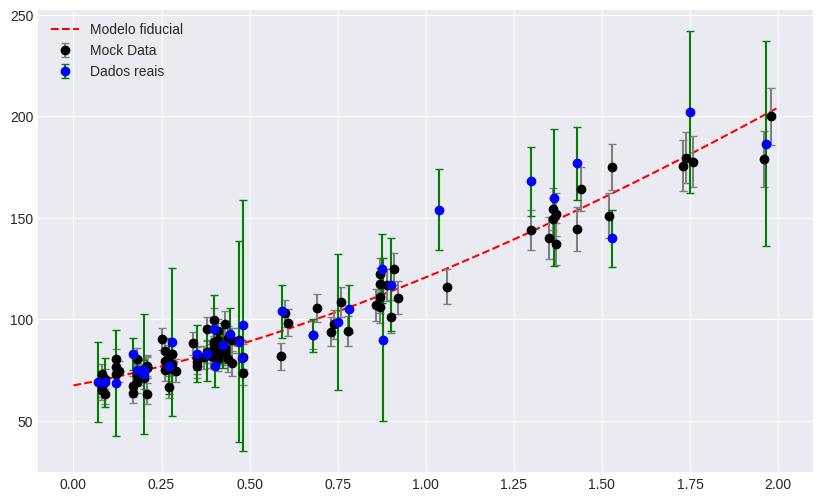

In [10]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(10, 6))

z_range = np.linspace(0, 2, 200)
H_theory_curve = flatLCDM(z_range, H0, Om)
ax.plot(z_range, H_theory_curve, color='red', linestyle='--', label="Modelo fiducial")
ax.errorbar(z_mock, H_obs, yerr=sigma_mock, fmt='o', color='black', ecolor='gray', capsize=3, label='Mock Data')
ax.errorbar(zhzi, hzi, yerr=shzi, fmt='o', color='blue', ecolor='green', capsize=3, label="Dados reais")
plt.legend()
plt.show()

In [11]:
%matplotlib inline
import emcee
import corner
import time
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
import scipy.integrate as integrate
import scipy.linalg as linalg
import IPython
from matplotlib.ticker import MaxNLocator
from multiprocessing.pool import ThreadPool
from getdist import plots, MCSamples, loadMCSamples, types
from scipy.special import gamma
from scipy.integrate import quad

global argsortz #array de indices de zsni ordenados

import os
os.environ["OMP_NUM_THREADS"] = "1"

np.random.seed(321)

In [12]:
zhzi = z_mock
hzi = H_obs
shzi = sigma_mock
ndata=len(zhzi)

In [17]:
pl.rcParams['text.usetex'] = True
pl.rcParams.update(pl.rcParamsDefault)
priorArray = np.array([[50., 100.], [0.0, 3.0], [-3.0, 3.0], [0.1, 2], [0.1, 2]])
nstepHz = 5000

In [15]:
#Function to identify which model will be used
def free_par(theta, freef, flat):
    if freef == True:
        if flat == False:
            h0, wm, wl, f1, f2 = theta
            return [h0, wm, wl, f1, f2]
        elif flat == True:
            h0, wm, f1, f2 = theta
            return [h0, wm, 1-wm, f1, f2]
        else:
            print("Invalid flatness...")
            return None
    elif freef == False:
        if flat == False:
            h0, wm, wl = theta
            return [h0, wm, wl, 1, 1]
        elif flat == True:
            h0, wm = theta
            return [h0, wm, 1-wm, 1, 1]
        else:
            print("Invalid flatness...")
            return None
    else:
        print("Invalid correction parameter...")
        return None

#Calculate chi2 for the model
def chi2Hz(par):
    E2 = par[1]*(1+zhzi)**3+(1-par[1]-par[2])*(1+zhzi)**2+par[2]

    if np.any(E2<0):
        return np.inf

    Hzm = par[0]*np.sqrt(E2)
    dhz = hzi-Hzm
    inv_covCorr = cov_mat(zhzi,par[3],par[4])

    return np.dot(np.dot(dhz.T, inv_covCorr), dhz)

#Check if parameters are in prior interval
def lnpriorHz(par):
    for i in range(len(par)):
        if not priorArray[i][0] < par[i] < priorArray[i][1]:
            return -np.inf
    return 0.0

#Calculate the likelihood
def lnlikeHz(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])

def lnlikeHzA(par):
    chi2 = chi2Hz(par)
    return -0.5*chi2 - ndata*np.log(par[3])


def lnprobHz(theta, freef, flat):
    par = free_par(theta, freef, flat)
    
    lp = lnpriorHz(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikeHz(par)

#Minimize chi2
def find_bestfit(lnlike, par_ml, parnames, freef, flat):
    t1 = time.time()
    ndim = len(par_ml)
    chi2 = lambda par_ml, freef, flat: -2*lnlike(par_ml, freef, flat)
    result = op.minimize(chi2, par_ml, args=(freef, flat))
    if not result['success']:
        result = op.minimize(chi2, par_ml, args=(freef, flat), method='Nelder-Mead', options={'maxiter': 10000})
    par_ml = result['x']
    print('Maximum likelihood result:')
    for i in range(ndim):
        print(parnames[i],' = ',par_ml[i])
    print('chi2min =',result['fun'])
    t2 = time.time()
    print('Total time: {0:5.3f} seg'.format(t2-t1))
    return result

#Run MC
def run_emcee(par_ml, nwalkers, lnprob, freef, flat, ainput, nsteps):
    ndim = len(par_ml)
    pos = [par_ml +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    with ThreadPool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[freef, flat], a=ainput, pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)
    
    accept = sampler.acceptance_fraction
    print('Acceptance fraction:',accept)
    print('Minimum acceptance:',np.amin(accept))
    print('Maximum acceptance:',np.amax(accept))
    
    return sampler

#Remove burn in
def tira_burnin(sampler, burnin, ndim):
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    return samples


def burninthin(sampler, tau):
    taumax = np.amax(tau)
    taumin = np.amin(tau)
    samples = sampler.get_chain(discard=int(2*taumax), thin=int(taumin/2), flat=True)
    print(samples.shape)
    return samples

#MC results
def MC_result(samples, par_ml, parnames):
    ndim = len(par_ml)
    par_mean = np.mean(samples,axis=0)
    par_median = np.percentile(samples, [50], axis=0)[0]
    par_valm = np.percentile(samples, [15.865525393149998], axis=0)[0]
    par_valp = np.percentile(samples, [84.13447460685], axis=0)[0]
    par_valm2 = np.percentile(samples, [2.275013194800002], axis=0)[0]
    par_valp2 = np.percentile(samples, [97.7249868052], axis=0)[0]
    par_sigm = par_mean - par_valm
    par_sigp = par_valp - par_mean
    par_sigm2 = par_mean - par_valm2
    par_sigp2 = par_valp2 - par_mean
    print('MCMC result:')
    for i in range(ndim):
        print("""{0} = {1:5.5f} +{2:5.5f} +{3:5.5f} -{4:5.5f} -{5:5.5f} (median: {6:5.5f}, ml: {7:5.5f})"""\
              .format(parnames[i],par_mean[i],par_sigp[i],par_sigp2[i],par_sigm[i],par_sigm2[i],par_median[i],par_ml[i]))

#Insert a derived paramater
def insertDerived(sample, parnames, parlabel, num, gsample, derived, derivedName, derivedLabel):
    n = np.zeros(num)
    
    if derivedName not in parnames:
        newSample = np.c_[sample, derived]
        parnames.append(derivedName)
        gsample.addDerived(derived, name=derivedName, label=derivedLabel)
        
        return newSample, gsample, parnames, n

    elif derivedName in parnames:
        print('Parâmetro dependente já adicionado.')

        return sample, gsample, parnames, n

#Distribution funcion for chi2
def chiDist(chi, n):
    return (n**(n/2)*((chi)**((n-2)/2))*np.exp(-(n/2)*chi))/(2**(n/2)*gamma(n/2))

#Calculate cdf for chiDist
def chiCDF(x, n):
    res = np.zeros_like(x)
    for i, val in enumerate(x):
        y, err = quad(chiDist, 0, val, args=(n))
        res[i]=y
    return res

#Plot chi2 cdf
def plotChiDist(chimin, par, name=0):
    n = ndata - par
    chi = np.linspace(0, 2.5, 500)
    chiv = np.full((500), chimin/n)
    hv = chiDist(chi, n)
    cdf = chiCDF(chi, n)
    y = np.linspace(0, 1.8, 500)
    
    pl.plot(chi, hv, label=r"$h _{\nu}$")
    pl.plot(chiv, y, '--', label=r"$\chi _{\nu} ^{2}$" + "$= {0}$".format(np.round(chimin/n, 3)))
    pl.plot(chi, cdf, '--', label="cdf")
    
    pl.xticks(np.arange(0.0, 2.51, 0.5))
    pl.yticks(np.arange(0.0, 1.76, 0.25))
    pl.axis((0, 2.5, 0, 1.75))
    pl.grid(linestyle='-.', linewidth='0.5')
    pl.minorticks_on()
    
    pl.ylabel(r'$h_{\nu}$')
    pl.xlabel(r'$\chi _{\nu} ^{2}$')
    pl.legend(loc='best')
   
    if not name == 0:
        pl.savefig(name+'.pdf')
    
    pl.show()

def getpar_PSHz_22(theta):
    M, h0, q0, j0, s0 = theta
    return lnprobPSHz_22(M, h0, q0, j0, s0)

def run_cobaya(info, info_post):
    print("----- INICIANDO SAMPLER -----")
    t1 = time.time()

    # Roda o sampler
    updated_info, sampler = run(info)

    # Retira o início 
    print("----- RETIRANDO O INICIO -----")
    updated_info_post, sampler_post = run(info_post)

    print(f"Tempo de execução: {time.time()-t1} s")

    return sampler, sampler_post

# No factor f

In [18]:
par_HzF = [69.1929957609451, 0.2480895086492853]
ndimF = len(par_HzF)
prefixF = 'FlatLcdmHz32Cov'
parlabelsF = ["H_0","\\Omega_m"]
parlabtexF = ["$H_0$","$\\Omega_m$"]
parnamesF = ['H0','wm']

resultHzF = find_bestfit(lnprobHz, par_HzF, parnamesF, freef=False, flat=True)
par_mlHzF = resultHzF['x']

Maximum likelihood result:
H0  =  59.23618559411845
wm  =  0.3755245899298425
chi2min = 93.12580264638122
Total time: 0.613 seg


In [19]:
samplerHzF = run_emcee(par_HzF, 100, lnprobHz, False, True, 2.0, nstepHz)

  0%|                                             | 8/5000 [00:09<1:38:14,  1.18s/it]


KeyboardInterrupt: 

In [16]:
tauHzF = samplerHzF.get_autocorr_time()
print(tauHzF)

tauHzmaxF = np.amax(tauHzF)
r = nstepHz/tauHzmaxF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[30.88991426 31.78910063]
157.28661399327092
Convergiu! :)


In [17]:
samplesHzFFF = burninthin(samplerHzF, tauHzF)

(32900, 2)


In [18]:
MC_result(samplesHzFFF, par_HzF, parnamesF)

MCMC result:
H0 = 67.83735 +0.94862 +1.86512 -0.94717 -1.90673 (median: 67.84433, ml: 69.19300)
wm = 0.30188 +0.01817 +0.03768 -0.01821 -0.03524 (median: 0.30144, ml: 0.24809)


In [19]:
gsamplesHzFFF = MCSamples(samples=samplesHzFFF, names=parnamesF, labels=parlabelsF, ranges={'wm':(0, None)})
gsamplesHzFFF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


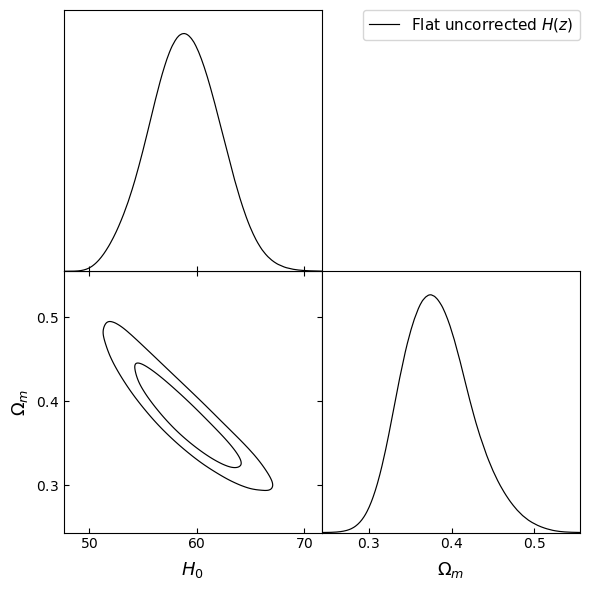

In [21]:
g = plots.getSubplotPlotter(width_inch=6)
g.triangle_plot([gsamplesHzFFF], filled=False, legend_labels=['Flat uncorrected $H(z)$'])
pl.show()
#g.export('fig/g'+prefixF+'All-triangle.pdf')

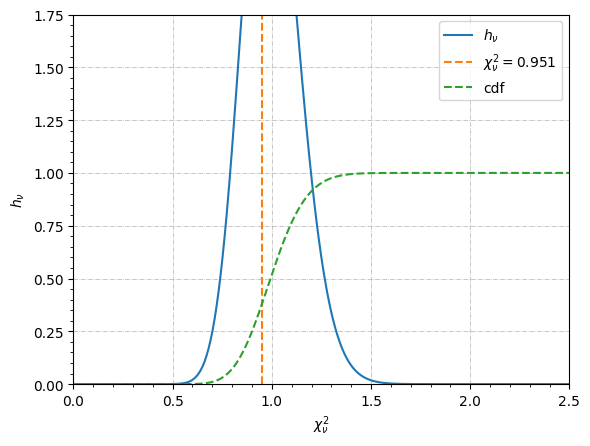

Probabilidade =  38.11822447909732
Chiv =  0.9507998224575243


In [22]:
chi2F=chi2Hz(free_par([58.90430,0.38259], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF), name='No_f')
chivFperc, errF = quad(chiDist, 0, chi2F/(ndata-len(par_HzF)), args=(ndata-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(ndata-len(par_HzF)))

# Colocando f

In [23]:
f = 1.21

In [24]:
cov_mat = f**2*cov_mat

inv_cov = linalg.inv(cov_mat)

In [25]:
par_HzF = [69.1929957609451, 0.2480895086492853]
ndimF = len(par_HzF)
prefixF = 'FlatLcdmHz32Cov'
parlabelsF = ["H_0","\\Omega_m"]
parlabtexF = ["$H_0$","$\\Omega_m$"]
parnamesF = ['H0','wm']

resultHzF = find_bestfit(lnprobHz, par_HzF, parnamesF, freef=False, flat=True)
par_mlHzF = resultHzF['x']

Maximum likelihood result:
H0  =  59.23619013417631
wm  =  0.3755245390411722
chi2min = 63.60617624914818
Total time: 0.014 seg


In [26]:
samplerHzF = run_emcee(par_HzF, 100, lnprobHz, False, True, 2.0, nstepHz)

100%|███████████████████████████████████████████| 5000/5000 [00:35<00:00, 139.47it/s]

Acceptance fraction: [0.704  0.7178 0.7074 0.7028 0.7064 0.7072 0.7074 0.71   0.7114 0.7198
 0.7106 0.7126 0.7178 0.7096 0.7134 0.7254 0.713  0.7096 0.7168 0.7148
 0.7118 0.7154 0.71   0.7056 0.716  0.7302 0.7154 0.7154 0.7204 0.716
 0.723  0.7156 0.7276 0.7166 0.7164 0.7062 0.7142 0.721  0.7164 0.7148
 0.6958 0.711  0.7154 0.716  0.7078 0.7206 0.7166 0.7184 0.721  0.7048
 0.7112 0.715  0.73   0.7154 0.708  0.7086 0.7146 0.7092 0.7048 0.7136
 0.697  0.7022 0.7202 0.715  0.7238 0.7152 0.7084 0.7086 0.7154 0.7198
 0.7136 0.712  0.7022 0.71   0.7178 0.7134 0.7188 0.7144 0.7078 0.7148
 0.7048 0.7118 0.7242 0.7174 0.7022 0.7204 0.7114 0.7034 0.7084 0.71
 0.712  0.7038 0.711  0.7098 0.7086 0.708  0.7136 0.7052 0.7144 0.7156]
Minimum acceptance: 0.6958
Maximum acceptance: 0.7302


In [27]:
tauHzF = samplerHzF.get_autocorr_time()
print(tauHzF)

tauHzmaxF = np.amax(tauHzF)
r = nstepHz/tauHzmaxF
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[34.91402899 34.38835405]
143.2089089751971
Convergiu! :)


In [28]:
samplesHzF = burninthin(samplerHzF, tauHzF)

(29000, 2)


In [29]:
MC_result(samplesHzF, par_HzF, parnamesF)

MCMC result:
H0 = 58.84316 +3.91603 +7.81145 -3.95343 -7.31699 (median: 58.78784, ml: 69.19300)
wm = 0.38443 +0.05048 +0.10790 -0.04944 -0.08811 (median: 0.38065, ml: 0.24809)


In [30]:
gsamplesHzF = MCSamples(samples=samplesHzF, names=parnamesF, labels=parlabelsF, ranges={'wm':(0, None)})
gsamplesHzF.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


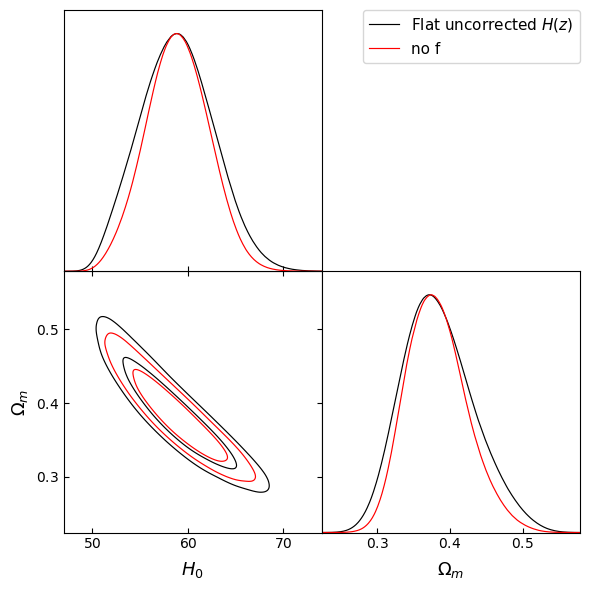

In [31]:
g = plots.getSubplotPlotter(width_inch=6)
g.triangle_plot([gsamplesHzF, gsamplesHzFFF], filled=False, legend_labels=['Flat uncorrected $H(z)$', 'no f'])
pl.show()
g.export('fig/comF_semF.pdf')

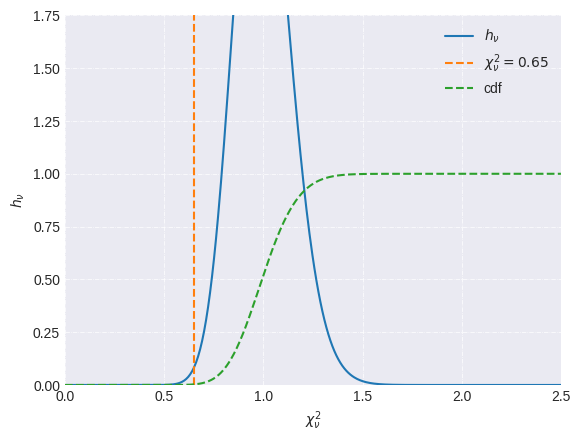

Probabilidade =  0.28244407030198354
Chiv =  0.6496761775163115


In [36]:
chi2F=chi2Hz(free_par([58.84316,0.38443], freef=False, flat=True))
plotChiDist(chi2F, len(par_HzF), 'com_f')
chivFperc, errF = quad(chiDist, 0, chi2F/(ndata-len(par_HzF)), args=(ndata-len(par_HzF)))
print('Probabilidade = ', chivFperc*100)
print('Chiv = ', chi2F/(ndata-len(par_HzF)))

# com f

In [34]:
par_HzFf = [69.1929957609451,0.2480895086492853, .9]
ndimFf = len(par_HzFf)
prefixFf = 'LcdmHz32CovCorr'
parlabelsFf = ['H_0','\\Omega_m', 'f']
parlabtexFf = ['$H_0$','$\\Omega_m$', '$f$']
parnamesFf = ['H0','wm', 'f']

resultHzFf = find_bestfit(lnprobHz, par_HzFf, parnamesFf, freef=True, flat=True)
par_mlHzFf = resultHzFf['x']

Maximum likelihood result:
H0  =  59.23618968457303
wm  =  0.37552454313590017
f  =  0.7975348071408929
chi2min = 54.754039047869846
Total time: 0.015 seg


In [35]:
samplerHzFf = run_emcee(par_HzFf, 100, lnprobHz, True, True, 2.0, nstepHz)

100%|███████████████████████████████████████████| 5000/5000 [00:32<00:00, 152.10it/s]

Acceptance fraction: [0.6448 0.6556 0.6356 0.6356 0.634  0.6492 0.6424 0.633  0.6406 0.6442
 0.6388 0.634  0.6342 0.643  0.6442 0.6496 0.651  0.6322 0.646  0.6426
 0.6362 0.638  0.6438 0.642  0.6544 0.6494 0.634  0.637  0.6448 0.6516
 0.637  0.641  0.6512 0.6536 0.654  0.637  0.6422 0.6488 0.6332 0.642
 0.6428 0.642  0.6534 0.645  0.644  0.643  0.6426 0.6464 0.6698 0.6508
 0.6334 0.6406 0.639  0.6346 0.6366 0.6482 0.6498 0.6338 0.6358 0.6444
 0.6252 0.637  0.6418 0.6438 0.6418 0.6372 0.645  0.6468 0.6316 0.6396
 0.6482 0.6392 0.631  0.6264 0.6508 0.65   0.6488 0.6408 0.641  0.6524
 0.6444 0.6514 0.649  0.6484 0.643  0.6472 0.634  0.6374 0.6384 0.6378
 0.6456 0.6378 0.654  0.6468 0.6456 0.6382 0.649  0.6398 0.6458 0.6346]
Minimum acceptance: 0.6252
Maximum acceptance: 0.6698


In [37]:
tauHzFf = samplerHzFf.get_autocorr_time()
print(tauHzFf)

tauHzmaxFf = np.amax(tauHzFf)
r = nstepHz/tauHzmaxFf
print(r)

if(r>50):
    print('Convergiu! :)')
else:
    print('Não convergiu... :\'(:' )

[42.70822451 41.8988439  38.16494464]
117.0734690545726
Convergiu! :)


In [38]:
samplesHzFf = burninthin(samplerHzFf, tauHzFf)

(25800, 3)


In [39]:
MC_result(samplesHzFf, par_mlHzFf, parnamesFf)

MCMC result:
H0 = 58.92859 +3.27747 +6.43136 -3.28415 -6.52978 (median: 58.91854, ml: 59.23619)
wm = 0.38231 +0.04103 +0.09348 -0.04089 -0.07347 (median: 0.37907, ml: 0.37552)
f = 0.81511 +0.05931 +0.12992 -0.05863 -0.10887 (median: 0.81132, ml: 0.79753)


In [40]:
gsamplesHzFf = MCSamples(samples=samplesHzFf, names=parnamesFf, labels=parlabelsFf, ranges={'wm':(0, None)})
gsamplesHzFf.updateSettings({'countours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


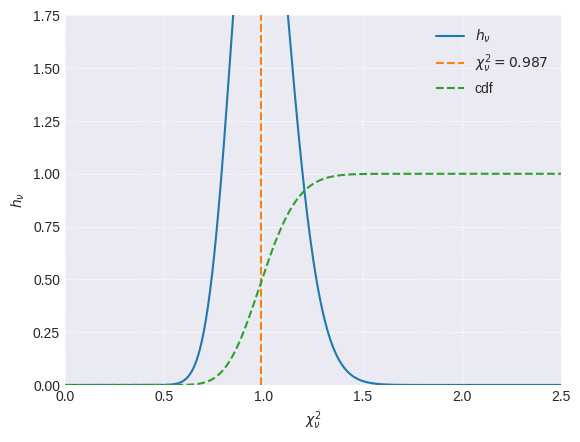

Probabilidade =  48.423369627548944
Chiv =  0.9874928644813801


In [41]:
chi2Ff=chi2Hz(free_par([58.92859,0.38231,0.81511], freef=True, flat=True))
plotChiDist(chi2Ff, len(par_HzFf), name='corrigido')
chivFfperc, errF = quad(chiDist, 0, chi2Ff/(ndata-len(par_HzFf)), args=(ndata-len(par_HzFf)))
print('Probabilidade = ', chivFfperc*100)
print('Chiv = ', chi2Ff/(ndata-len(par_HzFf)))

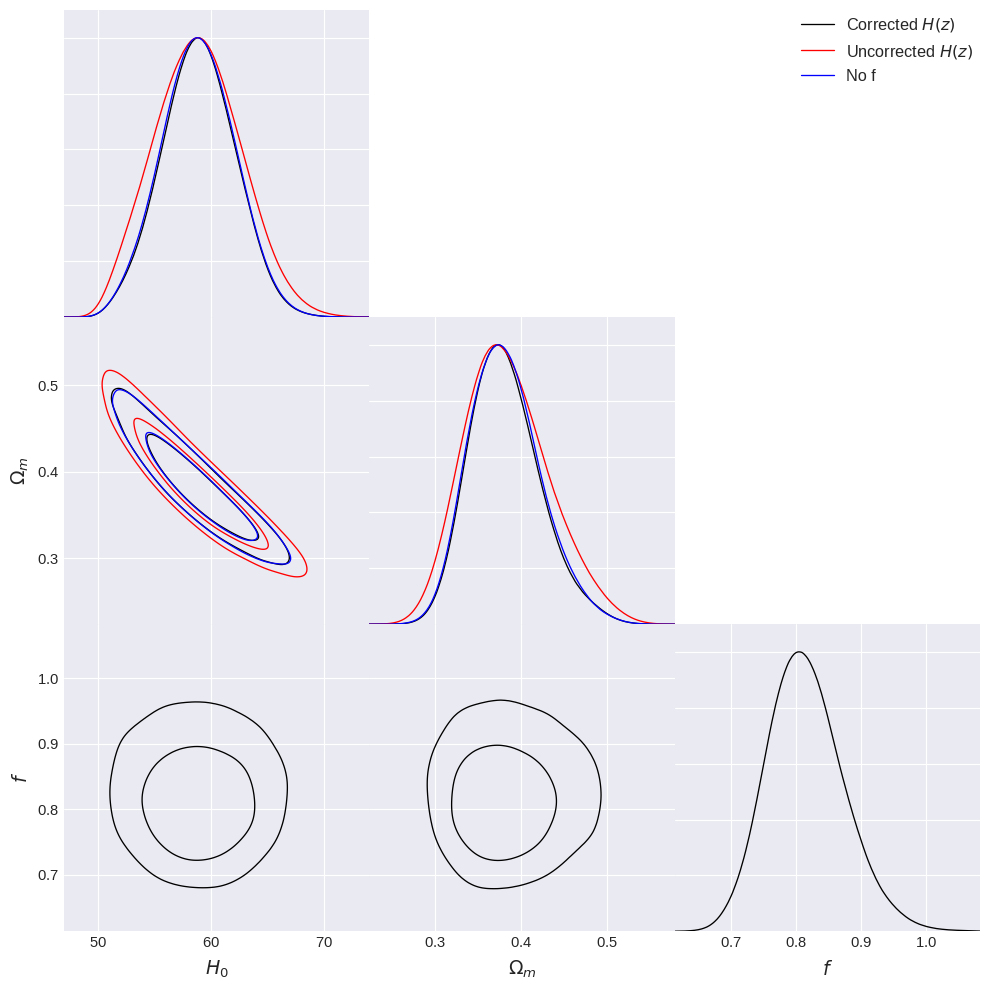

In [42]:
g = plots.getSubplotPlotter(width_inch=10)
g.triangle_plot([gsamplesHzFf, gsamplesHzF, gsamplesHzFFF], [parnamesFf[0],parnamesFf[1],parnamesFf[2]], filled=False, legend_labels=['Corrected $H(z)$','Uncorrected $H(z)$', 'No f'])
g.export('fig/triangle_ALL')
plt.show()